Set-up the Spark engine on local machine

In [1]:
import pandas as pd
from ggplot import *
import pyspark
conf = pyspark.SparkConf().setMaster("local").setAppName("Suicide_Rates")
sc = pyspark.SparkContext(conf = conf)
spark=pyspark.sql.SparkSession(sc)

/Users/milad/miniconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/milad/miniconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


In [2]:
from csv import reader
def Transform_Line(line):
    x=next(reader([line]))
    if x[0]=='country':
        return x
    x[1]=int(x[1])
    if x[3]=="5-14 years":
        x[3]="05-14 years"
    x[4]=int(x[4])
    x[5]=int(x[5])
    x[6]=float(x[6])
    x[9]=int(x[9].replace(",",""))
    x[10]=int(x[10])
    return x

In [3]:
rdd=sc.textFile("./DataSource.csv")
first_line=rdd.first()
rdd=rdd.filter(lambda x: x!=first_line).map(lambda x:Transform_Line(x))
header=['country','year','sex','age','suicides_no','population','suicides_per_100k','country_year','HDI_for_year','gdp_for_year','gdp_per_capita','generation']
df=rdd.toDF(header)
df=df.orderBy(['Country','year','sex','age'])
df.show()
df.registerTempTable("Suicide_Rate")

+-------+----+------+-----------+-----------+----------+-----------------+------------+------------+------------+--------------+---------------+
|country|year|   sex|        age|suicides_no|population|suicides_per_100k|country_year|HDI_for_year|gdp_for_year|gdp_per_capita|     generation|
+-------+----+------+-----------+-----------+----------+-----------------+------------+------------+------------+--------------+---------------+
|Albania|1987|female|05-14 years|          0|    311000|              0.0| Albania1987|            |  2156624900|           796|   Generation X|
|Albania|1987|female|15-24 years|         14|    289700|             4.83| Albania1987|            |  2156624900|           796|   Generation X|
|Albania|1987|female|25-34 years|          4|    257200|             1.56| Albania1987|            |  2156624900|           796|        Boomers|
|Albania|1987|female|35-54 years|          6|    278800|             2.15| Albania1987|            |  2156624900|           796|  

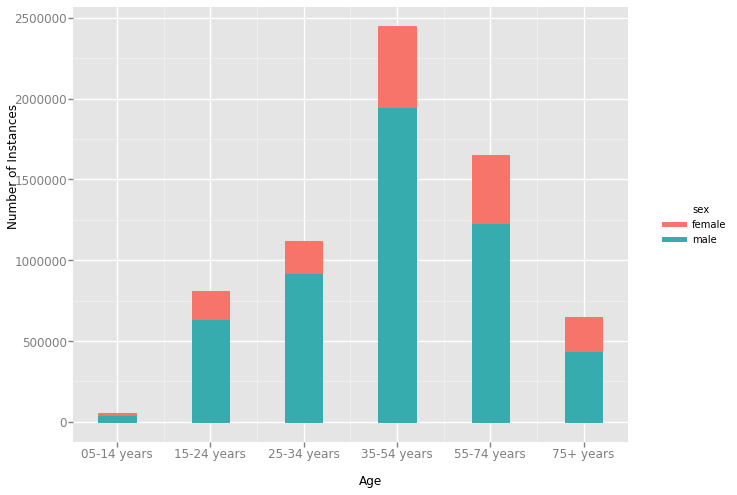

In [4]:
df_ByAge=spark.sql("""
SELECT sex,age as age,Round(MEAN(suicides_per_100k),10) as Average_Suicide_Rate_per_100k,SUM(suicides_no) as Number_Instnaces
FROM Suicide_Rate
WHERE year<2016
Group By sex,age
Order By age,sex
""").toPandas()
plot=(ggplot(aes(x='age', weight='Number_Instnaces',fill='sex'), data=df_ByAge) +geom_bar(stat='identity',position='stack'))+xlab('Age')+ylab('Number of Instances')
plot.show()

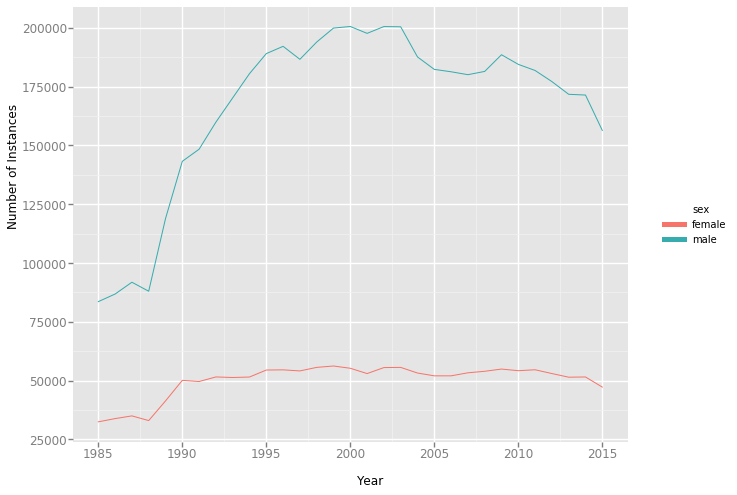

In [5]:
df_ByYear=spark.sql("""
SELECT year,sex,SUM(suicides_no) as Number_Instnaces
FROM Suicide_Rate
WHERE year < 2016
Group By sex,year
Order By year
""").toPandas()
plot=(ggplot(aes(x='year', y='Number_Instnaces',color='sex'), data=df_ByYear) +geom_line())+xlab('Year')+ylab('Number of Instances')
plot.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

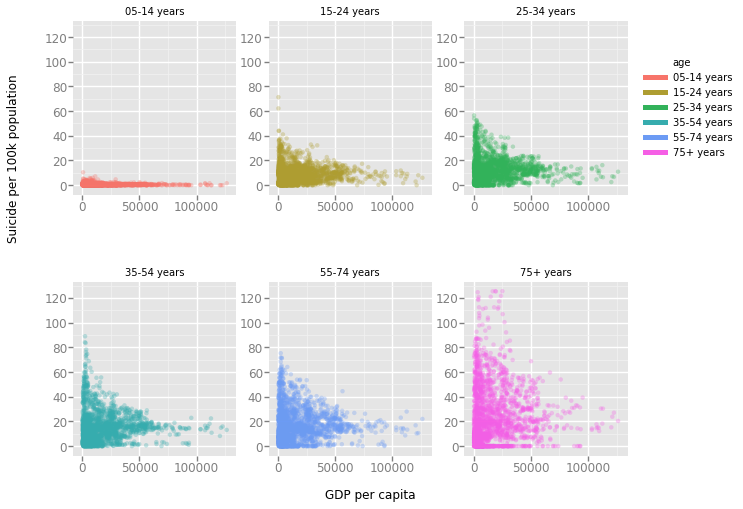

In [6]:
df_ByGDP=spark.sql("""
SELECT age,gdp_per_capita,MEAN(suicides_per_100k) as suicides_per_100k_avg
FROM Suicide_Rate
WHERE year < 2016
Group By gdp_per_capita,age
Order By gdp_per_capita
""").toPandas()
plot=(ggplot(aes(x='gdp_per_capita', y='suicides_per_100k_avg',color='age'),data=df_ByGDP) +geom_point(alpha=0.3)+facet_wrap("age",ncol=3))+xlab('GDP per capita')+ylab('Suicide per 100k population')
plot.show()